In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dateutil.relativedelta import relativedelta
from datetime import datetime


c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_excel('CPI_monthly_2025_changes.xlsx', skiprows=11)
df = df.drop(columns=['Series ID'])

# Keep only monthly data
df = df[df['Period'].str.startswith('M')]

# Convert 'Year' & 'Period' into a proper Date format
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Period'].str[1:] + '-01')

# Keep only relevant columns
df = df[['Date', 'Value']]
df.columns = ['timestamp', 'CPI']

# Set date as index
df = df.set_index('timestamp')

# Outlier Treatment
q1 = np.percentile(df['CPI'], 25)
q3 = np.percentile(df['CPI'], 75)
boolean_condition = (df['CPI'] < q1 - (q3-q1)*1.3) | (df['CPI'] > q3 + (q3-q1)*1.3)
df.loc[boolean_condition, 'CPI'] = np.mean(df['CPI'])


c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
# Convert to Prophet format
df_prophet = df.reset_index()[['timestamp', 'CPI']]
df_prophet.columns = ['ds', 'y']


In [4]:
train_size = int(0.9 * df_prophet.shape[0])
prophet_train = df_prophet.iloc[:train_size]
prophet_test = df_prophet.iloc[train_size:]


In [5]:
# # Initialize and train the Prophet model
# prophet_model = Prophet(seasonality_mode='additive', yearly_seasonality=True)
# prophet_model.fit(prophet_train)

# # Create future DataFrame (matching test period)
# future_dates = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='M')

# # Generate forecast
# forecast = prophet_model.predict(future_dates)

# # Set index to 'ds' for easy comparison
# forecast = forecast.set_index('ds')
# prophet_test = prophet_test.set_index('ds')

# # Extract only matching test period values
# common_dates = forecast.index.intersection(prophet_test.index)
# prophet_forecast = forecast.loc[common_dates, ['yhat']]


In [6]:
# Initialize and train Prophet
prophet_model = Prophet(seasonality_mode='additive', yearly_seasonality=True)
prophet_model.fit(prophet_train)

# Make future DataFrame
future_dates = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='M')

# Generate forecast
forecast = prophet_model.predict(future_dates)

# Ensure datetime format before setting index
if 'ds' in forecast.columns:
    forecast['ds'] = pd.to_datetime(forecast['ds'])
    forecast = forecast.set_index('ds')

if 'ds' in prophet_test.columns:
    prophet_test['ds'] = pd.to_datetime(prophet_test['ds'])
    prophet_test = prophet_test.set_index('ds')

# Find common dates between forecast and test data
common_dates = forecast.index.intersection(prophet_test.index)

# Extract only the matching rows
prophet_forecast = forecast.loc[common_dates, ['yhat']]




01:45:33 - cmdstanpy - INFO - Chain [1] start processing
01:45:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mkahs\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\mkahs\AppData\Local\Temp\ipykernel_21476\647114781.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_test['ds'] = pd.to_datetime(prophet_test['ds'])


In [7]:
print("Forecast Index Range:", forecast.index.min(), "to", forecast.index.max())
print("Prophet Test Index Range:", prophet_test.index.min(), "to", prophet_test.index.max())

# Print the last 10 dates in the forecast
print("\nForecast Last Dates:", forecast.index[-10:])
print("\nTest Data First Dates:", prophet_test.index[:10])


Forecast Index Range: 1913-02-01 00:00:00 to 2024-12-31 00:00:00
Prophet Test Index Range: 2013-11-01 00:00:00 to 2025-01-01 00:00:00

Forecast Last Dates: DatetimeIndex(['2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', name='ds', freq=None)

Test Data First Dates: DatetimeIndex(['2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01',
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01'],
              dtype='datetime64[ns]', name='ds', freq=None)


In [8]:
future_dates = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='M')


C:\Users\mkahs\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [9]:
# Ensure future_dates only includes test period dates
future_dates = pd.DataFrame({'ds': prophet_test.index}).reset_index(drop=True)


In [10]:
forecast = prophet_model.predict(future_dates)

# Set index to 'ds'
forecast = forecast.set_index('ds')

# Find common dates
common_dates = forecast.index.intersection(prophet_test.index)

# Ensure non-empty intersection
if len(common_dates) == 0:
    raise ValueError("No matching dates found between forecast and test data. Check your date formatting.")

# Extract only matching values
prophet_forecast = forecast.loc[common_dates, ['yhat']]


In [11]:
print("Fixed Prophet Forecast Data Sample:")
print(prophet_forecast.head())

print("\nFixed Prophet Test Data Sample:")
print(prophet_test.loc[prophet_forecast.index].head())

print("\nNumber of samples - Prophet Test:", len(prophet_test))
print("Number of samples - Prophet Forecast:", len(prophet_forecast))


Fixed Prophet Forecast Data Sample:
                yhat
ds                  
2013-11-01  0.146049
2013-12-01  0.108645
2014-01-01  0.208945
2014-02-01  0.225915
2014-03-01  0.241457

Fixed Prophet Test Data Sample:
              y
ds             
2013-11-01 -0.2
2013-12-01  0.0
2014-01-01  0.4
2014-02-01  0.4
2014-03-01  0.6

Number of samples - Prophet Test: 135
Number of samples - Prophet Forecast: 135


In [12]:
prophet_rmse = np.sqrt(mean_squared_error(prophet_test.loc[prophet_forecast.index, 'y'], prophet_forecast['yhat']))
prophet_mae = mean_absolute_error(prophet_test.loc[prophet_forecast.index, 'y'], prophet_forecast['yhat'])

print("Facebook Prophet Performance:")
print(f"RMSE: {prophet_rmse:.4f}")
print(f"MAE: {prophet_mae:.4f}")


Facebook Prophet Performance:
RMSE: 0.2930
MAE: 0.2313


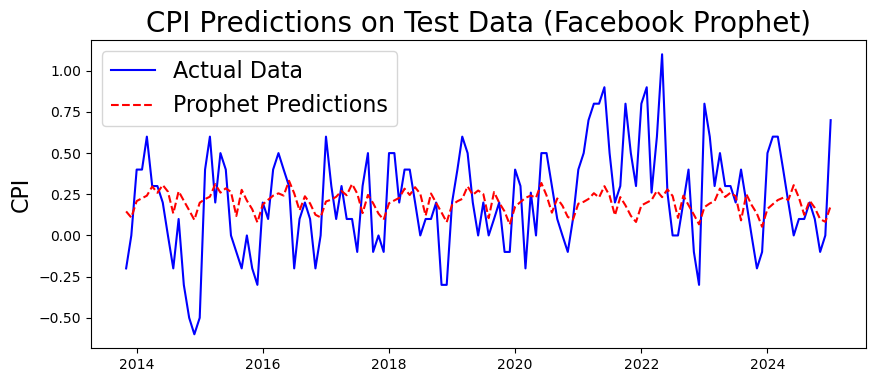

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.plot(prophet_test.index, prophet_test['y'], label='Actual Data', color='blue')
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet Predictions', linestyle='--', color='red')

plt.legend(fontsize=16)
plt.title('CPI Predictions on Test Data (Facebook Prophet)', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.show()


In [14]:
from dateutil.relativedelta import relativedelta
from prophet import Prophet
import pandas as pd
from datetime import datetime

# Rolling Forecast Setup
start_time = datetime(1913, 1, 1)
end_time = datetime(2014, 1, 1)
roll_end_time = end_time

# Use data up to `end_time` as the initial training set
prophet_roll_train = df_prophet.loc[df_prophet['ds'] <= end_time].copy()

# Initialize roll_forecast to avoid NameError
roll_forecast = pd.DataFrame()
rolling_forecast = []

while roll_end_time + relativedelta(months=+1) <= df_prophet['ds'].max():
    print(f"\nProcessing roll_end_time: {roll_end_time}")

    # Ensure there is enough training data
    if prophet_roll_train.shape[0] < 12:
        print(f"⚠️ Warning: Not enough training data ({prophet_roll_train.shape[0]} records). Skipping iteration.")
        break

    # Train Prophet model
    prophet_roll_model = Prophet(seasonality_mode='additive', yearly_seasonality=True)
    prophet_roll_model.fit(prophet_roll_train)

    # Predict next month
    next_month = roll_end_time + relativedelta(months=+1)
    future_dates = pd.DataFrame({'ds': [next_month]})

    # Debugging prints
    print(f"Future date being predicted: {next_month}")
    print("Future Dates Sample:\n", future_dates)

    # Generate forecast
    roll_forecast = prophet_roll_model.predict(future_dates)

    # Debugging: Check if forecast contains predictions
    print("Generated Forecast:\n", roll_forecast.head())

    if roll_forecast.empty:
        print(f"⚠️ No forecast generated for {roll_end_time} - check training data & future dates")
        break  # Stop loop if no predictions are generated

    # Extract the last predicted value correctly
    predicted_value = {
        'ds': roll_forecast.iloc[-1]['ds'],  # Timestamp
        'yhat': roll_forecast.iloc[-1]['yhat']  # Predicted CPI value
    }
    rolling_forecast.append(predicted_value)

    # Print progress
    print(f"✅ Rolling forecast for {predicted_value['ds']}: {predicted_value['yhat']}")

    # Move to next month
    roll_end_time = next_month

    # Append prediction to rolling training set
    new_entry = pd.DataFrame({'ds': [predicted_value['ds']], 'y': [predicted_value['yhat']]})
    prophet_roll_train = pd.concat([prophet_roll_train, new_entry], ignore_index=True)

# Convert rolling forecast list to DataFrame
if len(rolling_forecast) == 0:
    raise ValueError("⚠️ Rolling forecast list is empty. Ensure predictions were generated correctly.")

prophet_rolling_results = pd.DataFrame(rolling_forecast)

# Ensure 'ds' exists before converting
if 'ds' not in prophet_rolling_results.columns:
    raise KeyError("Column 'ds' not found in rolling forecast results. Check data structure.")

# Convert 'ds' to datetime
prophet_rolling_results['ds'] = pd.to_datetime(prophet_rolling_results['ds'])
prophet_rolling_results = prophet_rolling_results.set_index('ds')

# Print to confirm results
print("Fixed Prophet Rolling Forecast Sample:")
print(prophet_rolling_results.head())


01:45:34 - cmdstanpy - INFO - Chain [1] start processing



Processing roll_end_time: 2014-01-01 00:00:00


01:45:34 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2014-02-01 00:00:00
Future Dates Sample:
           ds
0 2014-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-02-01  0.232229   -0.182673    0.617344     0.232229     0.232229   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.003744              0.003744              0.003744  0.003744   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.003744      0.003744                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.235973  
✅ Rolling forecast for 2014-02-01 00:00:00: 0.23597297900827366

Processing roll_end_time: 2014-02-01 00:00:00


01:45:34 - cmdstanpy - INFO - Chain [1] start processing
01:45:35 - cmdstanpy - INFO - Chain [1] done processing
01:45:35 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2014-03-01 00:00:00
Future Dates Sample:
           ds
0 2014-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-03-01  0.230565   -0.186752    0.686981     0.230565     0.230565   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.020011              0.020011              0.020011  0.020011   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.020011      0.020011                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.250576  
✅ Rolling forecast for 2014-03-01 00:00:00: 0.25057553248851283

Processing roll_end_time: 2014-03-01 00:00:00


01:45:35 - cmdstanpy - INFO - Chain [1] done processing
01:45:35 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2014-04-01 00:00:00
Future Dates Sample:
           ds
0 2014-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-04-01  0.222701    -0.13406    0.742565     0.222701     0.222701   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.071285              0.071285              0.071285  0.071285   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.071285      0.071285                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.293986  
✅ Rolling forecast for 2014-04-01 00:00:00: 0.2939864912332546

Processing roll_end_time: 2014-04-01 00:00:00


01:45:35 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2014-05-01 00:00:00
Future Dates Sample:
           ds
0 2014-05-01
Generated Forecast:
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-05-01  0.22455   -0.149882    0.727202      0.22455      0.22455   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.037049              0.037049              0.037049  0.037049   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.037049      0.037049                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.261599  
✅ Rolling forecast for 2014-05-01 00:00:00: 0.26159927780840253

Processing roll_end_time: 2014-05-01 00:00:00


01:45:36 - cmdstanpy - INFO - Chain [1] start processing
01:45:36 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2014-06-01 00:00:00
Future Dates Sample:
           ds
0 2014-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-06-01  0.210475   -0.113205    0.710819     0.210475     0.210475   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0         0.08262               0.08262               0.08262  0.08262   

   yearly_lower  yearly_upper  multiplicative_terms  \
0       0.08262       0.08262                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.293095  
✅ Rolling forecast for 2014-06-01 00:00:00: 0.2930953950151753

Processing roll_end_time: 2014-06-01 00:00:00


01:45:36 - cmdstanpy - INFO - Chain [1] start processing
01:45:36 - cmdstanpy - INFO - Chain [1] done processing
01:45:36 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2014-07-01 00:00:00
Future Dates Sample:
           ds
0 2014-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-07-01  0.229859   -0.133616    0.701739     0.229859     0.229859   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.044674              0.044674              0.044674  0.044674   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.044674      0.044674                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.274534  
✅ Rolling forecast for 2014-07-01 00:00:00: 0.2745337682790285

Processing roll_end_time: 2014-07-01 00:00:00


01:45:37 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2014-08-01 00:00:00
Future Dates Sample:
           ds
0 2014-08-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-08-01  0.227755   -0.290419    0.557203     0.227755     0.227755   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.083491             -0.083491             -0.083491 -0.083491   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.083491     -0.083491                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.144264  
✅ Rolling forecast for 2014-08-01 00:00:00: 0.1442642920478271

Processing roll_end_time: 2014-08-01 00:00:00


01:45:37 - cmdstanpy - INFO - Chain [1] start processing
01:45:37 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2014-09-01 00:00:00
Future Dates Sample:
           ds
0 2014-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-09-01  0.232694   -0.166048    0.684746     0.232694     0.232694   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0         0.04391               0.04391               0.04391  0.04391   

   yearly_lower  yearly_upper  multiplicative_terms  \
0       0.04391       0.04391                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.276604  
✅ Rolling forecast for 2014-09-01 00:00:00: 0.2766035123849112

Processing roll_end_time: 2014-09-01 00:00:00


01:45:37 - cmdstanpy - INFO - Chain [1] start processing
01:45:37 - cmdstanpy - INFO - Chain [1] done processing
01:45:38 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2014-10-01 00:00:00
Future Dates Sample:
           ds
0 2014-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-10-01  0.224973   -0.203076    0.645085     0.224973     0.224973   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.010303             -0.010303             -0.010303 -0.010303   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.010303     -0.010303                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.214671  
✅ Rolling forecast for 2014-10-01 00:00:00: 0.2146706989312907

Processing roll_end_time: 2014-10-01 00:00:00


01:45:38 - cmdstanpy - INFO - Chain [1] done processing
01:45:38 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2014-11-01 00:00:00
Future Dates Sample:
           ds
0 2014-11-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-11-01  0.228106   -0.309801    0.543088     0.228106     0.228106   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.069439             -0.069439             -0.069439 -0.069439   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.069439     -0.069439                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.158666  
✅ Rolling forecast for 2014-11-01 00:00:00: 0.15866642006454432

Processing roll_end_time: 2014-11-01 00:00:00


01:45:38 - cmdstanpy - INFO - Chain [1] done processing
01:45:38 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2014-12-01 00:00:00
Future Dates Sample:
           ds
0 2014-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-12-01  0.229228   -0.316167    0.537539     0.229228     0.229228   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.122189             -0.122189             -0.122189 -0.122189   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.122189     -0.122189                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.107039  
✅ Rolling forecast for 2014-12-01 00:00:00: 0.10703860453126773

Processing roll_end_time: 2014-12-01 00:00:00


01:45:38 - cmdstanpy - INFO - Chain [1] done processing
01:45:39 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2015-01-01 00:00:00
Future Dates Sample:
           ds
0 2015-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-01-01  0.227294   -0.218498    0.603454     0.227294     0.227294   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.017505             -0.017505             -0.017505 -0.017505   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.017505     -0.017505                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.209789  
✅ Rolling forecast for 2015-01-01 00:00:00: 0.20978913396039245

Processing roll_end_time: 2015-01-01 00:00:00


01:45:39 - cmdstanpy - INFO - Chain [1] done processing
01:45:39 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2015-02-01 00:00:00
Future Dates Sample:
           ds
0 2015-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-02-01  0.223419   -0.185553    0.656117     0.223419     0.223419   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.002523              0.002523              0.002523  0.002523   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.002523      0.002523                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.225942  
✅ Rolling forecast for 2015-02-01 00:00:00: 0.22594155823373402

Processing roll_end_time: 2015-02-01 00:00:00


01:45:39 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-03-01 00:00:00
Future Dates Sample:
           ds
0 2015-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-03-01  0.212406   -0.174185    0.616791     0.212406     0.212406   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.015521              0.015521              0.015521  0.015521   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.015521      0.015521                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.227927  
✅ Rolling forecast for 2015-03-01 00:00:00: 0.22792702537438633

Processing roll_end_time: 2015-03-01 00:00:00


01:45:39 - cmdstanpy - INFO - Chain [1] start processing
01:45:40 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-04-01 00:00:00
Future Dates Sample:
           ds
0 2015-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-04-01  0.222394   -0.126948    0.739502     0.222394     0.222394   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.078236              0.078236              0.078236  0.078236   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.078236      0.078236                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.300631  
✅ Rolling forecast for 2015-04-01 00:00:00: 0.30063077722022635

Processing roll_end_time: 2015-04-01 00:00:00


01:45:40 - cmdstanpy - INFO - Chain [1] start processing
01:45:40 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-05-01 00:00:00
Future Dates Sample:
           ds
0 2015-05-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-05-01  0.222871   -0.155921    0.666369     0.222871     0.222871   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.038002              0.038002              0.038002  0.038002   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.038002      0.038002                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.260873  
✅ Rolling forecast for 2015-05-01 00:00:00: 0.2608729584032922

Processing roll_end_time: 2015-05-01 00:00:00


01:45:40 - cmdstanpy - INFO - Chain [1] start processing
01:45:40 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-06-01 00:00:00
Future Dates Sample:
           ds
0 2015-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-06-01  0.216311   -0.157469    0.698953     0.216311     0.216311   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.081844              0.081844              0.081844  0.081844   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.081844      0.081844                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.298155  
✅ Rolling forecast for 2015-06-01 00:00:00: 0.29815478677765483

Processing roll_end_time: 2015-06-01 00:00:00


01:45:40 - cmdstanpy - INFO - Chain [1] start processing
01:45:40 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-07-01 00:00:00
Future Dates Sample:
           ds
0 2015-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-07-01  0.220619   -0.135542    0.707567     0.220619     0.220619   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.045405              0.045405              0.045405  0.045405   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.045405      0.045405                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.266024  
✅ Rolling forecast for 2015-07-01 00:00:00: 0.26602445385214946

Processing roll_end_time: 2015-07-01 00:00:00


01:45:41 - cmdstanpy - INFO - Chain [1] start processing
01:45:41 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-08-01 00:00:00
Future Dates Sample:
           ds
0 2015-08-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-08-01  0.214746   -0.290233    0.483275     0.214746     0.214746   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.099987             -0.099987             -0.099987 -0.099987   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.099987     -0.099987                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.114758  
✅ Rolling forecast for 2015-08-01 00:00:00: 0.11475824677565064

Processing roll_end_time: 2015-08-01 00:00:00


01:45:41 - cmdstanpy - INFO - Chain [1] start processing
01:45:41 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-09-01 00:00:00
Future Dates Sample:
           ds
0 2015-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-09-01  0.229148   -0.121656    0.693295     0.229148     0.229148   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.057885              0.057885              0.057885  0.057885   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.057885      0.057885                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.287033  
✅ Rolling forecast for 2015-09-01 00:00:00: 0.28703270332849246

Processing roll_end_time: 2015-09-01 00:00:00


01:45:42 - cmdstanpy - INFO - Chain [1] start processing
01:45:42 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-10-01 00:00:00
Future Dates Sample:
           ds
0 2015-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-10-01  0.217593   -0.195368    0.642143     0.217593     0.217593   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.002994             -0.002994             -0.002994 -0.002994   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.002994     -0.002994                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.214599  
✅ Rolling forecast for 2015-10-01 00:00:00: 0.21459876162825686

Processing roll_end_time: 2015-10-01 00:00:00


01:45:42 - cmdstanpy - INFO - Chain [1] start processing
01:45:42 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-11-01 00:00:00
Future Dates Sample:
           ds
0 2015-11-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-11-01  0.217631   -0.255233     0.60087     0.217631     0.217631   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.068637             -0.068637             -0.068637 -0.068637   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.068637     -0.068637                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.148993  
✅ Rolling forecast for 2015-11-01 00:00:00: 0.1489930505075342

Processing roll_end_time: 2015-11-01 00:00:00


01:45:42 - cmdstanpy - INFO - Chain [1] start processing
01:45:42 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2015-12-01 00:00:00
Future Dates Sample:
           ds
0 2015-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2015-12-01  0.214801   -0.346794    0.505382     0.214801     0.214801   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.136751             -0.136751             -0.136751 -0.136751   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.136751     -0.136751                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.07805  
✅ Rolling forecast for 2015-12-01 00:00:00: 0.07805016000512652

Processing roll_end_time: 2015-12-01 00:00:00


01:45:43 - cmdstanpy - INFO - Chain [1] start processing
01:45:43 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-01-01 00:00:00
Future Dates Sample:
           ds
0 2016-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-01-01  0.214169   -0.205511    0.625182     0.214169     0.214169   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.026231             -0.026231             -0.026231 -0.026231   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.026231     -0.026231                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.187938  
✅ Rolling forecast for 2016-01-01 00:00:00: 0.18793802389179914

Processing roll_end_time: 2016-01-01 00:00:00


01:45:43 - cmdstanpy - INFO - Chain [1] start processing
01:45:43 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-02-01 00:00:00
Future Dates Sample:
           ds
0 2016-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-02-01  0.218002   -0.202096    0.613215     0.218002     0.218002   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.001407              0.001407              0.001407  0.001407   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.001407      0.001407                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.21941  
✅ Rolling forecast for 2016-02-01 00:00:00: 0.21940965409339505

Processing roll_end_time: 2016-02-01 00:00:00


01:45:43 - cmdstanpy - INFO - Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-03-01 00:00:00
Future Dates Sample:
           ds
0 2016-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-03-01  0.221043    -0.17163    0.648888     0.221043     0.221043   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.023106              0.023106              0.023106  0.023106   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.023106      0.023106                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.244149  
✅ Rolling forecast for 2016-03-01 00:00:00: 0.24414932470613399

Processing roll_end_time: 2016-03-01 00:00:00


01:45:44 - cmdstanpy - INFO - Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-04-01 00:00:00
Future Dates Sample:
           ds
0 2016-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-04-01  0.221961   -0.128488    0.687718     0.221961     0.221961   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0         0.04413               0.04413               0.04413  0.04413   

   yearly_lower  yearly_upper  multiplicative_terms  \
0       0.04413       0.04413                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.266091  
✅ Rolling forecast for 2016-04-01 00:00:00: 0.26609110559707505

Processing roll_end_time: 2016-04-01 00:00:00


01:45:44 - cmdstanpy - INFO - Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing
01:45:45 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2016-05-01 00:00:00
Future Dates Sample:
           ds
0 2016-05-01
Generated Forecast:
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-05-01  0.22614   -0.160409     0.65166      0.22614      0.22614   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.031441              0.031441              0.031441  0.031441   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.031441      0.031441                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.257581  
✅ Rolling forecast for 2016-05-01 00:00:00: 0.25758112684409984

Processing roll_end_time: 2016-05-01 00:00:00


01:45:45 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-06-01 00:00:00
Future Dates Sample:
           ds
0 2016-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-06-01  0.217444   -0.068609    0.769156     0.217444     0.217444   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0         0.10571               0.10571               0.10571  0.10571   

   yearly_lower  yearly_upper  multiplicative_terms  \
0       0.10571       0.10571                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.323154  
✅ Rolling forecast for 2016-06-01 00:00:00: 0.3231538961890275

Processing roll_end_time: 2016-06-01 00:00:00


01:45:45 - cmdstanpy - INFO - Chain [1] start processing
01:45:45 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-07-01 00:00:00
Future Dates Sample:
           ds
0 2016-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-07-01  0.219274   -0.126407    0.680281     0.219274     0.219274   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.043444              0.043444              0.043444  0.043444   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.043444      0.043444                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.262719  
✅ Rolling forecast for 2016-07-01 00:00:00: 0.2627185029905527

Processing roll_end_time: 2016-07-01 00:00:00


01:45:45 - cmdstanpy - INFO - Chain [1] start processing
01:45:45 - cmdstanpy - INFO - Chain [1] done processing
01:45:46 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2016-08-01 00:00:00
Future Dates Sample:
           ds
0 2016-08-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-08-01  0.222164   -0.258807    0.530544     0.222164     0.222164   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.072532             -0.072532             -0.072532 -0.072532   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.072532     -0.072532                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.149632  
✅ Rolling forecast for 2016-08-01 00:00:00: 0.1496319728482808

Processing roll_end_time: 2016-08-01 00:00:00


01:45:46 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-09-01 00:00:00
Future Dates Sample:
           ds
0 2016-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-09-01  0.217466   -0.169035    0.674059     0.217466     0.217466   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.032428              0.032428              0.032428  0.032428   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.032428      0.032428                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.249895  
✅ Rolling forecast for 2016-09-01 00:00:00: 0.2498946264386236

Processing roll_end_time: 2016-09-01 00:00:00


01:45:46 - cmdstanpy - INFO - Chain [1] start processing
01:45:46 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-10-01 00:00:00
Future Dates Sample:
           ds
0 2016-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-10-01  0.221721   -0.204488    0.648448     0.221721     0.221721   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.016595             -0.016595             -0.016595 -0.016595   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.016595     -0.016595                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.205125  
✅ Rolling forecast for 2016-10-01 00:00:00: 0.20512504199449041

Processing roll_end_time: 2016-10-01 00:00:00


01:45:46 - cmdstanpy - INFO - Chain [1] start processing
01:45:47 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-11-01 00:00:00
Future Dates Sample:
           ds
0 2016-11-01
Generated Forecast:
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-11-01  0.22063   -0.305555    0.551629      0.22063      0.22063   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.084033             -0.084033             -0.084033 -0.084033   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.084033     -0.084033                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.136597  
✅ Rolling forecast for 2016-11-01 00:00:00: 0.13659693076048177

Processing roll_end_time: 2016-11-01 00:00:00


01:45:47 - cmdstanpy - INFO - Chain [1] start processing
01:45:47 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2016-12-01 00:00:00
Future Dates Sample:
           ds
0 2016-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-12-01  0.213091   -0.297473    0.492872     0.213091     0.213091   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.106787             -0.106787             -0.106787 -0.106787   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.106787     -0.106787                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.106303  
✅ Rolling forecast for 2016-12-01 00:00:00: 0.106303300701626

Processing roll_end_time: 2016-12-01 00:00:00


01:45:47 - cmdstanpy - INFO - Chain [1] start processing
01:45:47 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-01-01 00:00:00
Future Dates Sample:
           ds
0 2017-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-01-01  0.212324   -0.189032    0.627379     0.212324     0.212324   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.008561             -0.008561             -0.008561 -0.008561   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.008561     -0.008561                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.203763  
✅ Rolling forecast for 2017-01-01 00:00:00: 0.20376252018279348

Processing roll_end_time: 2017-01-01 00:00:00


01:45:47 - cmdstanpy - INFO - Chain [1] start processing
01:45:48 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-02-01 00:00:00
Future Dates Sample:
           ds
0 2017-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-02-01  0.211842   -0.239677    0.605942     0.211842     0.211842   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.005421              0.005421              0.005421  0.005421   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.005421      0.005421                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.217263  
✅ Rolling forecast for 2017-02-01 00:00:00: 0.21726282130233257

Processing roll_end_time: 2017-02-01 00:00:00


01:45:48 - cmdstanpy - INFO - Chain [1] start processing
01:45:48 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-03-01 00:00:00
Future Dates Sample:
           ds
0 2017-03-01
Generated Forecast:
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-03-01  0.21495   -0.188147     0.63468      0.21495      0.21495   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0         0.02226               0.02226               0.02226  0.02226   

   yearly_lower  yearly_upper  multiplicative_terms  \
0       0.02226       0.02226                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.23721  
✅ Rolling forecast for 2017-03-01 00:00:00: 0.23720976168759844

Processing roll_end_time: 2017-03-01 00:00:00


01:45:48 - cmdstanpy - INFO - Chain [1] start processing
01:45:48 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-04-01 00:00:00
Future Dates Sample:
           ds
0 2017-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-04-01  0.213025   -0.129686     0.67516     0.213025     0.213025   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.059814              0.059814              0.059814  0.059814   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.059814      0.059814                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.27284  
✅ Rolling forecast for 2017-04-01 00:00:00: 0.2728398530625006

Processing roll_end_time: 2017-04-01 00:00:00


01:45:48 - cmdstanpy - INFO - Chain [1] start processing
01:45:49 - cmdstanpy - INFO - Chain [1] done processing
01:45:49 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2017-05-01 00:00:00
Future Dates Sample:
           ds
0 2017-05-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-05-01  0.217493   -0.133231    0.663021     0.217493     0.217493   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.033597              0.033597              0.033597  0.033597   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.033597      0.033597                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.251091  
✅ Rolling forecast for 2017-05-01 00:00:00: 0.2510907084497108

Processing roll_end_time: 2017-05-01 00:00:00


01:45:49 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-06-01 00:00:00
Future Dates Sample:
           ds
0 2017-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-06-01  0.210495   -0.105159    0.732317     0.210495     0.210495   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.099256              0.099256              0.099256  0.099256   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.099256      0.099256                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.309751  
✅ Rolling forecast for 2017-06-01 00:00:00: 0.30975091660449855

Processing roll_end_time: 2017-06-01 00:00:00


01:45:49 - cmdstanpy - INFO - Chain [1] start processing
01:45:49 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-07-01 00:00:00
Future Dates Sample:
           ds
0 2017-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-07-01  0.217866   -0.183886    0.644152     0.217866     0.217866   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.043952              0.043952              0.043952  0.043952   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.043952      0.043952                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.261817  
✅ Rolling forecast for 2017-07-01 00:00:00: 0.26181739420311556

Processing roll_end_time: 2017-07-01 00:00:00


01:45:49 - cmdstanpy - INFO - Chain [1] start processing
01:45:50 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-08-01 00:00:00
Future Dates Sample:
           ds
0 2017-08-01
Generated Forecast:
           ds   trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-08-01  0.2167   -0.288952    0.569639       0.2167       0.2167   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.077188             -0.077188             -0.077188 -0.077188   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.077188     -0.077188                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.139512  
✅ Rolling forecast for 2017-08-01 00:00:00: 0.13951216957110105

Processing roll_end_time: 2017-08-01 00:00:00


01:45:50 - cmdstanpy - INFO - Chain [1] start processing
01:45:50 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-09-01 00:00:00
Future Dates Sample:
           ds
0 2017-09-01
Generated Forecast:
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-09-01  0.20599    -0.17909     0.61917      0.20599      0.20599   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.036487              0.036487              0.036487  0.036487   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.036487      0.036487                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.242477  
✅ Rolling forecast for 2017-09-01 00:00:00: 0.2424772551398938

Processing roll_end_time: 2017-09-01 00:00:00


01:45:50 - cmdstanpy - INFO - Chain [1] start processing
01:45:50 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-10-01 00:00:00
Future Dates Sample:
           ds
0 2017-10-01
Generated Forecast:
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-10-01  0.20835   -0.230979    0.602543      0.20835      0.20835   

   additive_terms  additive_terms_lower  additive_terms_upper  yearly  \
0         -0.0132               -0.0132               -0.0132 -0.0132   

   yearly_lower  yearly_upper  multiplicative_terms  \
0       -0.0132       -0.0132                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.19515  
✅ Rolling forecast for 2017-10-01 00:00:00: 0.19514950322148875

Processing roll_end_time: 2017-10-01 00:00:00


01:45:50 - cmdstanpy - INFO - Chain [1] start processing
01:45:51 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2017-11-01 00:00:00
Future Dates Sample:
           ds
0 2017-11-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-11-01  0.207171   -0.245644    0.524939     0.207171     0.207171   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.079137             -0.079137             -0.079137 -0.079137   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.079137     -0.079137                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.128034  
✅ Rolling forecast for 2017-11-01 00:00:00: 0.1280341649272328

Processing roll_end_time: 2017-11-01 00:00:00


01:45:51 - cmdstanpy - INFO - Chain [1] start processing
01:45:51 - cmdstanpy - INFO - Chain [1] done processing
01:45:51 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2017-12-01 00:00:00
Future Dates Sample:
           ds
0 2017-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-12-01  0.200093   -0.307269    0.518159     0.200093     0.200093   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0        -0.11504              -0.11504              -0.11504 -0.11504   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      -0.11504      -0.11504                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.085053  
✅ Rolling forecast for 2017-12-01 00:00:00: 0.08505340702290907

Processing roll_end_time: 2017-12-01 00:00:00


01:45:51 - cmdstanpy - INFO - Chain [1] done processing
01:45:52 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2018-01-01 00:00:00
Future Dates Sample:
           ds
0 2018-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-01-01  0.208738   -0.181483    0.625138     0.208738     0.208738   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.012491             -0.012491             -0.012491 -0.012491   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.012491     -0.012491                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.196247  
✅ Rolling forecast for 2018-01-01 00:00:00: 0.19624716832852032

Processing roll_end_time: 2018-01-01 00:00:00


01:45:52 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2018-02-01 00:00:00
Future Dates Sample:
           ds
0 2018-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-02-01  0.212083   -0.202039    0.609795     0.212083     0.212083   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.003833              0.003833              0.003833  0.003833   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.003833      0.003833                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.215916  
✅ Rolling forecast for 2018-02-01 00:00:00: 0.2159158287862734

Processing roll_end_time: 2018-02-01 00:00:00


01:45:52 - cmdstanpy - INFO - Chain [1] start processing
01:45:52 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2018-03-01 00:00:00
Future Dates Sample:
           ds
0 2018-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-03-01  0.218333   -0.175339    0.661829     0.218333     0.218333   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.020176              0.020176              0.020176  0.020176   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.020176      0.020176                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.238509  
✅ Rolling forecast for 2018-03-01 00:00:00: 0.23850943770122615

Processing roll_end_time: 2018-03-01 00:00:00


01:45:52 - cmdstanpy - INFO - Chain [1] start processing
01:45:52 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2018-04-01 00:00:00
Future Dates Sample:
           ds
0 2018-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-04-01  0.216748   -0.134015    0.697176     0.216748     0.216748   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.073389              0.073389              0.073389  0.073389   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.073389      0.073389                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.290137  
✅ Rolling forecast for 2018-04-01 00:00:00: 0.2901373899332943

Processing roll_end_time: 2018-04-01 00:00:00


01:45:53 - cmdstanpy - INFO - Chain [1] start processing
01:45:53 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2018-05-01 00:00:00
Future Dates Sample:
           ds
0 2018-05-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-05-01  0.214175    -0.14558    0.654409     0.214175     0.214175   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.036609              0.036609              0.036609  0.036609   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.036609      0.036609                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.250784  
✅ Rolling forecast for 2018-05-01 00:00:00: 0.2507844011073287

Processing roll_end_time: 2018-05-01 00:00:00


01:45:53 - cmdstanpy - INFO - Chain [1] start processing
01:45:53 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2018-06-01 00:00:00
Future Dates Sample:
           ds
0 2018-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-06-01  0.206824   -0.103715    0.704219     0.206824     0.206824   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.085901              0.085901              0.085901  0.085901   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.085901      0.085901                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.292725  
✅ Rolling forecast for 2018-06-01 00:00:00: 0.29272476759505506

Processing roll_end_time: 2018-06-01 00:00:00


01:45:53 - cmdstanpy - INFO - Chain [1] start processing
01:45:53 - cmdstanpy - INFO - Chain [1] done processing
01:45:54 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2018-07-01 00:00:00
Future Dates Sample:
           ds
0 2018-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-07-01  0.212321   -0.161507     0.68303     0.212321     0.212321   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.045268              0.045268              0.045268  0.045268   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.045268      0.045268                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.257589  
✅ Rolling forecast for 2018-07-01 00:00:00: 0.257588787746378

Processing roll_end_time: 2018-07-01 00:00:00


01:45:54 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2018-08-01 00:00:00
Future Dates Sample:
           ds
0 2018-08-01
Generated Forecast:
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-08-01  0.21618   -0.298602    0.552785      0.21618      0.21618   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.085595             -0.085595             -0.085595 -0.085595   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.085595     -0.085595                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.130585  
✅ Rolling forecast for 2018-08-01 00:00:00: 0.13058515321721006

Processing roll_end_time: 2018-08-01 00:00:00


01:45:54 - cmdstanpy - INFO - Chain [1] start processing
01:45:54 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2018-09-01 00:00:00
Future Dates Sample:
           ds
0 2018-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-09-01  0.197154   -0.151325     0.65053     0.197154     0.197154   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.047528              0.047528              0.047528  0.047528   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.047528      0.047528                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.244683  
✅ Rolling forecast for 2018-09-01 00:00:00: 0.24468256810865663

Processing roll_end_time: 2018-09-01 00:00:00


01:45:54 - cmdstanpy - INFO - Chain [1] start processing
01:45:54 - cmdstanpy - INFO - Chain [1] done processing
01:45:55 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2018-10-01 00:00:00
Future Dates Sample:
           ds
0 2018-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-10-01  0.212052   -0.181606    0.603383     0.212052     0.212052   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.009671             -0.009671             -0.009671 -0.009671   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.009671     -0.009671                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.202381  
✅ Rolling forecast for 2018-10-01 00:00:00: 0.20238138696754268

Processing roll_end_time: 2018-10-01 00:00:00


01:45:55 - cmdstanpy - INFO - Chain [1] done processing
01:45:55 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2018-11-01 00:00:00
Future Dates Sample:
           ds
0 2018-11-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-11-01  0.211802   -0.280124     0.54785     0.211802     0.211802   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.070652             -0.070652             -0.070652 -0.070652   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.070652     -0.070652                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.14115  
✅ Rolling forecast for 2018-11-01 00:00:00: 0.1411501775651284

Processing roll_end_time: 2018-11-01 00:00:00


01:45:55 - cmdstanpy - INFO - Chain [1] done processing
01:45:55 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2018-12-01 00:00:00
Future Dates Sample:
           ds
0 2018-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-12-01  0.211307   -0.322869    0.530097     0.211307     0.211307   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0        -0.12557              -0.12557              -0.12557 -0.12557   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      -0.12557      -0.12557                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.085737  
✅ Rolling forecast for 2018-12-01 00:00:00: 0.08573722676056175

Processing roll_end_time: 2018-12-01 00:00:00


01:45:55 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-01-01 00:00:00
Future Dates Sample:
           ds
0 2019-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-01-01  0.213818   -0.207261    0.605114     0.213818     0.213818   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.018615             -0.018615             -0.018615 -0.018615   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.018615     -0.018615                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.195203  
✅ Rolling forecast for 2019-01-01 00:00:00: 0.195202904843561

Processing roll_end_time: 2019-01-01 00:00:00


01:45:56 - cmdstanpy - INFO - Chain [1] start processing
01:45:56 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-02-01 00:00:00
Future Dates Sample:
           ds
0 2019-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-02-01  0.216005   -0.215588    0.629451     0.216005     0.216005   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.002336              0.002336              0.002336  0.002336   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.002336      0.002336                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.218341  
✅ Rolling forecast for 2019-02-01 00:00:00: 0.21834093458161824

Processing roll_end_time: 2019-02-01 00:00:00


01:45:56 - cmdstanpy - INFO - Chain [1] start processing
01:45:56 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-03-01 00:00:00
Future Dates Sample:
           ds
0 2019-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-03-01  0.216711   -0.157121    0.638286     0.216711     0.216711   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.019178              0.019178              0.019178  0.019178   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.019178      0.019178                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.235889  
✅ Rolling forecast for 2019-03-01 00:00:00: 0.23588861056544103

Processing roll_end_time: 2019-03-01 00:00:00


01:45:56 - cmdstanpy - INFO - Chain [1] start processing
01:45:56 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-04-01 00:00:00
Future Dates Sample:
           ds
0 2019-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-04-01  0.218631   -0.074983    0.707149     0.218631     0.218631   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.078976              0.078976              0.078976  0.078976   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.078976      0.078976                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.297607  
✅ Rolling forecast for 2019-04-01 00:00:00: 0.2976065258893972

Processing roll_end_time: 2019-04-01 00:00:00


01:45:57 - cmdstanpy - INFO - Chain [1] start processing
01:45:57 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-05-01 00:00:00
Future Dates Sample:
           ds
0 2019-05-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-05-01  0.208751   -0.173501    0.642896     0.208751     0.208751   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.038826              0.038826              0.038826  0.038826   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.038826      0.038826                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.247577  
✅ Rolling forecast for 2019-05-01 00:00:00: 0.24757696574037985

Processing roll_end_time: 2019-05-01 00:00:00


01:45:57 - cmdstanpy - INFO - Chain [1] start processing
01:45:57 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-06-01 00:00:00
Future Dates Sample:
           ds
0 2019-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-06-01  0.207079   -0.111642    0.702785     0.207079     0.207079   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.084398              0.084398              0.084398  0.084398   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.084398      0.084398                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.291477  
✅ Rolling forecast for 2019-06-01 00:00:00: 0.2914771919192853

Processing roll_end_time: 2019-06-01 00:00:00


01:45:57 - cmdstanpy - INFO - Chain [1] start processing
01:45:58 - cmdstanpy - INFO - Chain [1] done processing
01:45:58 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2019-07-01 00:00:00
Future Dates Sample:
           ds
0 2019-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-07-01  0.200283   -0.176212    0.654002     0.200283     0.200283   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.047146              0.047146              0.047146  0.047146   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.047146      0.047146                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.247429  
✅ Rolling forecast for 2019-07-01 00:00:00: 0.24742915302507923

Processing roll_end_time: 2019-07-01 00:00:00


01:45:58 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-08-01 00:00:00
Future Dates Sample:
           ds
0 2019-08-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-08-01  0.206887   -0.294729    0.510733     0.206887     0.206887   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.100876             -0.100876             -0.100876 -0.100876   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.100876     -0.100876                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.106011  
✅ Rolling forecast for 2019-08-01 00:00:00: 0.10601104734592731

Processing roll_end_time: 2019-08-01 00:00:00


01:45:58 - cmdstanpy - INFO - Chain [1] start processing
01:45:58 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-09-01 00:00:00
Future Dates Sample:
           ds
0 2019-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-09-01  0.209984   -0.171159    0.647262     0.209984     0.209984   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.053893              0.053893              0.053893  0.053893   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.053893      0.053893                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.263877  
✅ Rolling forecast for 2019-09-01 00:00:00: 0.263877118336765

Processing roll_end_time: 2019-09-01 00:00:00


01:45:59 - cmdstanpy - INFO - Chain [1] start processing
01:45:59 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-10-01 00:00:00
Future Dates Sample:
           ds
0 2019-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-10-01  0.205048   -0.189388    0.607562     0.205048     0.205048   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.001404             -0.001404             -0.001404 -0.001404   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.001404     -0.001404                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.203644  
✅ Rolling forecast for 2019-10-01 00:00:00: 0.20364442751851267

Processing roll_end_time: 2019-10-01 00:00:00


01:45:59 - cmdstanpy - INFO - Chain [1] start processing
01:45:59 - cmdstanpy - INFO - Chain [1] done processing
01:45:59 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2019-11-01 00:00:00
Future Dates Sample:
           ds
0 2019-11-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-11-01  0.214246   -0.272753    0.572084     0.214246     0.214246   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.070634             -0.070634             -0.070634 -0.070634   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.070634     -0.070634                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.143612  
✅ Rolling forecast for 2019-11-01 00:00:00: 0.14361161892469465

Processing roll_end_time: 2019-11-01 00:00:00


01:45:59 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2019-12-01 00:00:00
Future Dates Sample:
           ds
0 2019-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2019-12-01  0.205964   -0.330409    0.466725     0.205964     0.205964   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.130735             -0.130735             -0.130735 -0.130735   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.130735     -0.130735                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.07523  
✅ Rolling forecast for 2019-12-01 00:00:00: 0.07522953259121806

Processing roll_end_time: 2019-12-01 00:00:00


01:46:00 - cmdstanpy - INFO - Chain [1] start processing
01:46:00 - cmdstanpy - INFO - Chain [1] done processing
01:46:00 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2020-01-01 00:00:00
Future Dates Sample:
           ds
0 2020-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-01-01  0.204818   -0.252846    0.565199     0.204818     0.204818   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.021507             -0.021507             -0.021507 -0.021507   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.021507     -0.021507                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.183311  
✅ Rolling forecast for 2020-01-01 00:00:00: 0.18331095998001984

Processing roll_end_time: 2020-01-01 00:00:00


01:46:00 - cmdstanpy - INFO - Chain [1] done processing
01:46:00 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2020-02-01 00:00:00
Future Dates Sample:
           ds
0 2020-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-02-01  0.210873   -0.194701    0.624838     0.210873     0.210873   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.001445              0.001445              0.001445  0.001445   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.001445      0.001445                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.212318  
✅ Rolling forecast for 2020-02-01 00:00:00: 0.2123178129448527

Processing roll_end_time: 2020-02-01 00:00:00


01:46:00 - cmdstanpy - INFO - Chain [1] done processing
01:46:01 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2020-03-01 00:00:00
Future Dates Sample:
           ds
0 2020-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-03-01  0.208324    -0.16775    0.652942     0.208324     0.208324   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.023563              0.023563              0.023563  0.023563   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.023563      0.023563                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.231886  
✅ Rolling forecast for 2020-03-01 00:00:00: 0.23188646711521307

Processing roll_end_time: 2020-03-01 00:00:00


01:46:01 - cmdstanpy - INFO - Chain [1] done processing
01:46:01 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2020-04-01 00:00:00
Future Dates Sample:
           ds
0 2020-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-04-01  0.187856    -0.20502    0.613708     0.187856     0.187856   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.021021              0.021021              0.021021  0.021021   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.021021      0.021021                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.208877  
✅ Rolling forecast for 2020-04-01 00:00:00: 0.20887688953066444

Processing roll_end_time: 2020-04-01 00:00:00


01:46:01 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2020-05-01 00:00:00
Future Dates Sample:
           ds
0 2020-05-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-05-01  0.209515   -0.206615    0.633092     0.209515     0.209515   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.031568              0.031568              0.031568  0.031568   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.031568      0.031568                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.241084  
✅ Rolling forecast for 2020-05-01 00:00:00: 0.24108371044371735

Processing roll_end_time: 2020-05-01 00:00:00


01:46:01 - cmdstanpy - INFO - Chain [1] start processing
01:46:01 - cmdstanpy - INFO - Chain [1] done processing
01:46:02 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2020-06-01 00:00:00
Future Dates Sample:
           ds
0 2020-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-06-01  0.206504   -0.071211    0.688353     0.206504     0.206504   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.104874              0.104874              0.104874  0.104874   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.104874      0.104874                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.311378  
✅ Rolling forecast for 2020-06-01 00:00:00: 0.3113777723776467

Processing roll_end_time: 2020-06-01 00:00:00


01:46:02 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2020-07-01 00:00:00
Future Dates Sample:
           ds
0 2020-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-07-01  0.212672   -0.185719    0.656615     0.212672     0.212672   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.042116              0.042116              0.042116  0.042116   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.042116      0.042116                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.254788  
✅ Rolling forecast for 2020-07-01 00:00:00: 0.2547883214593592

Processing roll_end_time: 2020-07-01 00:00:00


01:46:02 - cmdstanpy - INFO - Chain [1] start processing
01:46:02 - cmdstanpy - INFO - Chain [1] done processing
01:46:02 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2020-08-01 00:00:00
Future Dates Sample:
           ds
0 2020-08-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-08-01  0.209859   -0.281699    0.567438     0.209859     0.209859   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.073107             -0.073107             -0.073107 -0.073107   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.073107     -0.073107                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.136752  
✅ Rolling forecast for 2020-08-01 00:00:00: 0.13675200960178152

Processing roll_end_time: 2020-08-01 00:00:00


01:46:02 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2020-09-01 00:00:00
Future Dates Sample:
           ds
0 2020-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-09-01  0.208805   -0.167522    0.661792     0.208805     0.208805   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.033467              0.033467              0.033467  0.033467   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.033467      0.033467                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.242272  
✅ Rolling forecast for 2020-09-01 00:00:00: 0.24227230956920978

Processing roll_end_time: 2020-09-01 00:00:00


01:46:03 - cmdstanpy - INFO - Chain [1] start processing
01:46:03 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2020-10-01 00:00:00
Future Dates Sample:
           ds
0 2020-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-10-01  0.205806   -0.199088    0.618436     0.205806     0.205806   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.014779             -0.014779             -0.014779 -0.014779   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.014779     -0.014779                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.191028  
✅ Rolling forecast for 2020-10-01 00:00:00: 0.19102758051278945

Processing roll_end_time: 2020-10-01 00:00:00


01:46:03 - cmdstanpy - INFO - Chain [1] start processing
01:46:03 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2020-11-01 00:00:00
Future Dates Sample:
           ds
0 2020-11-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-11-01  0.207699   -0.274117    0.523132     0.207699     0.207699   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.081631             -0.081631             -0.081631 -0.081631   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.081631     -0.081631                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.126068  
✅ Rolling forecast for 2020-11-01 00:00:00: 0.1260677784387036

Processing roll_end_time: 2020-11-01 00:00:00


01:46:03 - cmdstanpy - INFO - Chain [1] start processing
01:46:03 - cmdstanpy - INFO - Chain [1] done processing
01:46:04 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2020-12-01 00:00:00
Future Dates Sample:
           ds
0 2020-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2020-12-01  0.210199   -0.299553    0.516914     0.210199     0.210199   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0        -0.10479              -0.10479              -0.10479 -0.10479   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      -0.10479      -0.10479                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.105409  
✅ Rolling forecast for 2020-12-01 00:00:00: 0.10540878708638862

Processing roll_end_time: 2020-12-01 00:00:00


01:46:04 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2021-01-01 00:00:00
Future Dates Sample:
           ds
0 2021-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-01-01  0.209695   -0.221109    0.585127     0.209695     0.209695   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.010413             -0.010413             -0.010413 -0.010413   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.010413     -0.010413                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.199283  
✅ Rolling forecast for 2021-01-01 00:00:00: 0.1992825252273353

Processing roll_end_time: 2021-01-01 00:00:00


01:46:04 - cmdstanpy - INFO - Chain [1] start processing
01:46:04 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2021-02-01 00:00:00
Future Dates Sample:
           ds
0 2021-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-02-01  0.206192   -0.169684    0.628482     0.206192     0.206192   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.006128              0.006128              0.006128  0.006128   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.006128      0.006128                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.21232  
✅ Rolling forecast for 2021-02-01 00:00:00: 0.21232015103757096

Processing roll_end_time: 2021-02-01 00:00:00


01:46:04 - cmdstanpy - INFO - Chain [1] start processing
01:46:04 - cmdstanpy - INFO - Chain [1] done processing
01:46:05 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2021-03-01 00:00:00
Future Dates Sample:
           ds
0 2021-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-03-01  0.200198   -0.150429    0.644644     0.200198     0.200198   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.021876              0.021876              0.021876  0.021876   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.021876      0.021876                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.222074  
✅ Rolling forecast for 2021-03-01 00:00:00: 0.22207407457843267

Processing roll_end_time: 2021-03-01 00:00:00


01:46:05 - cmdstanpy - INFO - Chain [1] done processing
01:46:05 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2021-04-01 00:00:00
Future Dates Sample:
           ds
0 2021-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-04-01  0.198017   -0.151765    0.673022     0.198017     0.198017   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.061788              0.061788              0.061788  0.061788   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.061788      0.061788                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.259805  
✅ Rolling forecast for 2021-04-01 00:00:00: 0.2598048747223353

Processing roll_end_time: 2021-04-01 00:00:00


01:46:05 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2021-05-01 00:00:00
Future Dates Sample:
           ds
0 2021-05-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-05-01  0.198215   -0.176573    0.660401     0.198215     0.198215   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.033757              0.033757              0.033757  0.033757   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.033757      0.033757                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.231972  
✅ Rolling forecast for 2021-05-01 00:00:00: 0.2319720112735666

Processing roll_end_time: 2021-05-01 00:00:00


01:46:05 - cmdstanpy - INFO - Chain [1] start processing
01:46:05 - cmdstanpy - INFO - Chain [1] done processing
01:46:05 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2021-06-01 00:00:00
Future Dates Sample:
           ds
0 2021-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-06-01  0.203876   -0.130138    0.693655     0.203876     0.203876   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0         0.09666               0.09666               0.09666  0.09666   

   yearly_lower  yearly_upper  multiplicative_terms  \
0       0.09666       0.09666                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.300536  
✅ Rolling forecast for 2021-06-01 00:00:00: 0.3005359499534539

Processing roll_end_time: 2021-06-01 00:00:00


01:46:06 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2021-07-01 00:00:00
Future Dates Sample:
           ds
0 2021-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-07-01  0.195794   -0.146527    0.646369     0.195794     0.195794   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.043562              0.043562              0.043562  0.043562   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.043562      0.043562                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.239355  
✅ Rolling forecast for 2021-07-01 00:00:00: 0.23935520202108435

Processing roll_end_time: 2021-07-01 00:00:00


01:46:06 - cmdstanpy - INFO - Chain [1] start processing
01:46:06 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2021-08-01 00:00:00
Future Dates Sample:
           ds
0 2021-08-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-08-01  0.206452    -0.27822    0.504825     0.206452     0.206452   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.075793             -0.075793             -0.075793 -0.075793   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.075793     -0.075793                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.130659  
✅ Rolling forecast for 2021-08-01 00:00:00: 0.13065896652480757

Processing roll_end_time: 2021-08-01 00:00:00


01:46:06 - cmdstanpy - INFO - Chain [1] start processing
01:46:06 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2021-09-01 00:00:00
Future Dates Sample:
           ds
0 2021-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-09-01  0.204593   -0.174028    0.642165     0.204593     0.204593   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.034905              0.034905              0.034905  0.034905   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.034905      0.034905                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.239499  
✅ Rolling forecast for 2021-09-01 00:00:00: 0.23949887789730015

Processing roll_end_time: 2021-09-01 00:00:00


01:46:06 - cmdstanpy - INFO - Chain [1] start processing
01:46:07 - cmdstanpy - INFO - Chain [1] done processing
01:46:07 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2021-10-01 00:00:00
Future Dates Sample:
           ds
0 2021-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-10-01  0.197528   -0.221236     0.56214     0.197528     0.197528   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.012736             -0.012736             -0.012736 -0.012736   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.012736     -0.012736                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.184792  
✅ Rolling forecast for 2021-10-01 00:00:00: 0.1847919639781818

Processing roll_end_time: 2021-10-01 00:00:00


01:46:07 - cmdstanpy - INFO - Chain [1] done processing
01:46:07 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2021-11-01 00:00:00
Future Dates Sample:
           ds
0 2021-11-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-11-01  0.205216   -0.289634    0.518688     0.205216     0.205216   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.077485             -0.077485             -0.077485 -0.077485   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.077485     -0.077485                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.127731  
✅ Rolling forecast for 2021-11-01 00:00:00: 0.12773090134256326

Processing roll_end_time: 2021-11-01 00:00:00


01:46:07 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2021-12-01 00:00:00
Future Dates Sample:
           ds
0 2021-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-12-01  0.196059   -0.324851    0.471567     0.196059     0.196059   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.116329             -0.116329             -0.116329 -0.116329   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.116329     -0.116329                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.079729  
✅ Rolling forecast for 2021-12-01 00:00:00: 0.07972930412169128

Processing roll_end_time: 2021-12-01 00:00:00


01:46:07 - cmdstanpy - INFO - Chain [1] start processing
01:46:08 - cmdstanpy - INFO - Chain [1] done processing
01:46:08 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2022-01-01 00:00:00
Future Dates Sample:
           ds
0 2022-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-01-01  0.207794   -0.216961    0.615149     0.207794     0.207794   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.013328             -0.013328             -0.013328 -0.013328   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.013328     -0.013328                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.194466  
✅ Rolling forecast for 2022-01-01 00:00:00: 0.1944657387326416

Processing roll_end_time: 2022-01-01 00:00:00


01:46:08 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2022-02-01 00:00:00
Future Dates Sample:
           ds
0 2022-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-02-01  0.199168   -0.212753    0.600451     0.199168     0.199168   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.003921              0.003921              0.003921  0.003921   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.003921      0.003921                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.203089  
✅ Rolling forecast for 2022-02-01 00:00:00: 0.20308939241185037

Processing roll_end_time: 2022-02-01 00:00:00


01:46:08 - cmdstanpy - INFO - Chain [1] start processing
01:46:08 - cmdstanpy - INFO - Chain [1] done processing
01:46:08 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2022-03-01 00:00:00
Future Dates Sample:
           ds
0 2022-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-03-01  0.207415   -0.187198    0.654954     0.207415     0.207415   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.020124              0.020124              0.020124  0.020124   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.020124      0.020124                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.227538  
✅ Rolling forecast for 2022-03-01 00:00:00: 0.2275382310013877

Processing roll_end_time: 2022-03-01 00:00:00


01:46:08 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2022-04-01 00:00:00
Future Dates Sample:
           ds
0 2022-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-04-01  0.196518   -0.117747    0.662721     0.196518     0.196518   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.071276              0.071276              0.071276  0.071276   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.071276      0.071276                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.267794  
✅ Rolling forecast for 2022-04-01 00:00:00: 0.2677944970772031

Processing roll_end_time: 2022-04-01 00:00:00


01:46:09 - cmdstanpy - INFO - Chain [1] start processing
01:46:09 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2022-05-01 00:00:00
Future Dates Sample:
           ds
0 2022-05-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-05-01  0.193454   -0.183603    0.647391     0.193454     0.193454   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0         0.03718               0.03718               0.03718  0.03718   

   yearly_lower  yearly_upper  multiplicative_terms  \
0       0.03718       0.03718                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.230634  
✅ Rolling forecast for 2022-05-01 00:00:00: 0.23063382665035365

Processing roll_end_time: 2022-05-01 00:00:00


01:46:09 - cmdstanpy - INFO - Chain [1] start processing
01:46:09 - cmdstanpy - INFO - Chain [1] done processing
01:46:09 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2022-06-01 00:00:00
Future Dates Sample:
           ds
0 2022-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-06-01  0.197418   -0.106576    0.695441     0.197418     0.197418   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.088216              0.088216              0.088216  0.088216   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.088216      0.088216                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.285635  
✅ Rolling forecast for 2022-06-01 00:00:00: 0.2856348554521608

Processing roll_end_time: 2022-06-01 00:00:00


01:46:09 - cmdstanpy - INFO - Chain [1] done processing
01:46:10 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2022-07-01 00:00:00
Future Dates Sample:
           ds
0 2022-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-07-01  0.201093   -0.169702    0.643101     0.201093     0.201093   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.044646              0.044646              0.044646  0.044646   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.044646      0.044646                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.245739  
✅ Rolling forecast for 2022-07-01 00:00:00: 0.24573874449066851

Processing roll_end_time: 2022-07-01 00:00:00


01:46:10 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2022-08-01 00:00:00
Future Dates Sample:
           ds
0 2022-08-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-08-01  0.197748     -0.2523    0.552957     0.197748     0.197748   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.084938             -0.084938             -0.084938 -0.084938   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.084938     -0.084938                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.11281  
✅ Rolling forecast for 2022-08-01 00:00:00: 0.11281014689823152

Processing roll_end_time: 2022-08-01 00:00:00


01:46:10 - cmdstanpy - INFO - Chain [1] start processing
01:46:10 - cmdstanpy - INFO - Chain [1] done processing
01:46:10 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2022-09-01 00:00:00
Future Dates Sample:
           ds
0 2022-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-09-01  0.200049    -0.16352    0.670201     0.200049     0.200049   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.045579              0.045579              0.045579  0.045579   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.045579      0.045579                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.245629  
✅ Rolling forecast for 2022-09-01 00:00:00: 0.24562859288751138

Processing roll_end_time: 2022-09-01 00:00:00


01:46:10 - cmdstanpy - INFO - Chain [1] done processing
01:46:11 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2022-10-01 00:00:00
Future Dates Sample:
           ds
0 2022-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-10-01  0.193709   -0.218629    0.573498     0.193709     0.193709   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.010143             -0.010143             -0.010143 -0.010143   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.010143     -0.010143                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.183566  
✅ Rolling forecast for 2022-10-01 00:00:00: 0.1835657167553099

Processing roll_end_time: 2022-10-01 00:00:00


01:46:11 - cmdstanpy - INFO - Chain [1] done processing
01:46:11 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2022-11-01 00:00:00
Future Dates Sample:
           ds
0 2022-11-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-11-01  0.195602   -0.283951    0.528786     0.195602     0.195602   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.071653             -0.071653             -0.071653 -0.071653   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.071653     -0.071653                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.123949  
✅ Rolling forecast for 2022-11-01 00:00:00: 0.12394859545450827

Processing roll_end_time: 2022-11-01 00:00:00


01:46:11 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2022-12-01 00:00:00
Future Dates Sample:
           ds
0 2022-12-01
Generated Forecast:
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-12-01  0.20031   -0.327385    0.480082      0.20031      0.20031   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.123869             -0.123869             -0.123869 -0.123869   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.123869     -0.123869                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.076441  
✅ Rolling forecast for 2022-12-01 00:00:00: 0.0764406584255598

Processing roll_end_time: 2022-12-01 00:00:00


01:46:11 - cmdstanpy - INFO - Chain [1] start processing
01:46:11 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2023-01-01 00:00:00
Future Dates Sample:
           ds
0 2023-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-01-01  0.199035   -0.232145     0.57783     0.199035     0.199035   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.017423             -0.017423             -0.017423 -0.017423   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.017423     -0.017423                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.181612  
✅ Rolling forecast for 2023-01-01 00:00:00: 0.1816118810748684

Processing roll_end_time: 2023-01-01 00:00:00


01:46:11 - cmdstanpy - INFO - Chain [1] start processing
01:46:12 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2023-02-01 00:00:00
Future Dates Sample:
           ds
0 2023-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-02-01  0.198477   -0.196644    0.623549     0.198477     0.198477   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.002501              0.002501              0.002501  0.002501   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.002501      0.002501                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.200978  
✅ Rolling forecast for 2023-02-01 00:00:00: 0.20097839458322178

Processing roll_end_time: 2023-02-01 00:00:00


01:46:12 - cmdstanpy - INFO - Chain [1] start processing
01:46:12 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2023-03-01 00:00:00
Future Dates Sample:
           ds
0 2023-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-03-01  0.194722   -0.202949    0.626674     0.194722     0.194722   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.018129              0.018129              0.018129  0.018129   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.018129      0.018129                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.212852  
✅ Rolling forecast for 2023-03-01 00:00:00: 0.21285163053325618

Processing roll_end_time: 2023-03-01 00:00:00


01:46:12 - cmdstanpy - INFO - Chain [1] start processing
01:46:12 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2023-04-01 00:00:00
Future Dates Sample:
           ds
0 2023-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-04-01  0.194252   -0.109827    0.685956     0.194252     0.194252   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.087304              0.087304              0.087304  0.087304   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.087304      0.087304                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.281555  
✅ Rolling forecast for 2023-04-01 00:00:00: 0.2815554720078366

Processing roll_end_time: 2023-04-01 00:00:00


01:46:13 - cmdstanpy - INFO - Chain [1] start processing
01:46:13 - cmdstanpy - INFO - Chain [1] done processing
01:46:13 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2023-05-01 00:00:00
Future Dates Sample:
           ds
0 2023-05-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-05-01  0.188686    -0.14616    0.608822     0.188686     0.188686   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.040728              0.040728              0.040728  0.040728   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.040728      0.040728                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.229414  
✅ Rolling forecast for 2023-05-01 00:00:00: 0.2294144738473889

Processing roll_end_time: 2023-05-01 00:00:00


01:46:13 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2023-06-01 00:00:00
Future Dates Sample:
           ds
0 2023-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-06-01  0.193322   -0.154079    0.662431     0.193322     0.193322   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.073443              0.073443              0.073443  0.073443   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.073443      0.073443                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.266765  
✅ Rolling forecast for 2023-06-01 00:00:00: 0.266765128282371

Processing roll_end_time: 2023-06-01 00:00:00


01:46:13 - cmdstanpy - INFO - Chain [1] start processing
01:46:13 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2023-07-01 00:00:00
Future Dates Sample:
           ds
0 2023-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-07-01  0.188963   -0.140443    0.631439     0.188963     0.188963   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.046548              0.046548              0.046548  0.046548   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.046548      0.046548                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.235511  
✅ Rolling forecast for 2023-07-01 00:00:00: 0.23551056732642134

Processing roll_end_time: 2023-07-01 00:00:00


01:46:13 - cmdstanpy - INFO - Chain [1] start processing
01:46:14 - cmdstanpy - INFO - Chain [1] done processing
01:46:14 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2023-08-01 00:00:00
Future Dates Sample:
           ds
0 2023-08-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-08-01  0.188742   -0.290585    0.497713     0.188742     0.188742   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.095832             -0.095832             -0.095832 -0.095832   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.095832     -0.095832                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                         0.0                         0.0  0.09291  
✅ Rolling forecast for 2023-08-01 00:00:00: 0.09290988552012616

Processing roll_end_time: 2023-08-01 00:00:00


01:46:14 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2023-09-01 00:00:00
Future Dates Sample:
           ds
0 2023-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-09-01  0.193959   -0.173826    0.649998     0.193959     0.193959   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.056076              0.056076              0.056076  0.056076   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.056076      0.056076                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.250035  
✅ Rolling forecast for 2023-09-01 00:00:00: 0.2500347528563191

Processing roll_end_time: 2023-09-01 00:00:00


01:46:14 - cmdstanpy - INFO - Chain [1] start processing
01:46:14 - cmdstanpy - INFO - Chain [1] done processing
01:46:14 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2023-10-01 00:00:00
Future Dates Sample:
           ds
0 2023-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-10-01  0.191116   -0.212633    0.596788     0.191116     0.191116   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.005102             -0.005102             -0.005102 -0.005102   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.005102     -0.005102                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.186014  
✅ Rolling forecast for 2023-10-01 00:00:00: 0.18601402692546357

Processing roll_end_time: 2023-10-01 00:00:00


01:46:15 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2023-11-01 00:00:00
Future Dates Sample:
           ds
0 2023-11-01
Generated Forecast:
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-11-01  0.19052   -0.288515    0.528195      0.19052      0.19052   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.063331             -0.063331             -0.063331 -0.063331   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.063331     -0.063331                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.127189  
✅ Rolling forecast for 2023-11-01 00:00:00: 0.12718916940549632

Processing roll_end_time: 2023-11-01 00:00:00


01:46:15 - cmdstanpy - INFO - Chain [1] start processing
01:46:15 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2023-12-01 00:00:00
Future Dates Sample:
           ds
0 2023-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-12-01  0.196263   -0.316511     0.47517     0.196263     0.196263   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.132592             -0.132592             -0.132592 -0.132592   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.132592     -0.132592                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.063671  
✅ Rolling forecast for 2023-12-01 00:00:00: 0.06367071205029906

Processing roll_end_time: 2023-12-01 00:00:00


01:46:15 - cmdstanpy - INFO - Chain [1] start processing
01:46:15 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-01-01 00:00:00
Future Dates Sample:
           ds
0 2024-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-01-01  0.197026   -0.222719    0.562341     0.197026     0.197026   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.023814             -0.023814             -0.023814 -0.023814   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.023814     -0.023814                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.173212  
✅ Rolling forecast for 2024-01-01 00:00:00: 0.17321232028085115

Processing roll_end_time: 2024-01-01 00:00:00


01:46:16 - cmdstanpy - INFO - Chain [1] start processing
01:46:16 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-02-01 00:00:00
Future Dates Sample:
           ds
0 2024-02-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-02-01  0.192151   -0.210905    0.573365     0.192151     0.192151   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.000936              0.000936              0.000936  0.000936   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.000936      0.000936                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.193087  
✅ Rolling forecast for 2024-02-01 00:00:00: 0.19308738054237565

Processing roll_end_time: 2024-02-01 00:00:00


01:46:16 - cmdstanpy - INFO - Chain [1] start processing
01:46:16 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-03-01 00:00:00
Future Dates Sample:
           ds
0 2024-03-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-03-01  0.194783   -0.202171    0.638453     0.194783     0.194783   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.025255              0.025255              0.025255  0.025255   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.025255      0.025255                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.220038  
✅ Rolling forecast for 2024-03-01 00:00:00: 0.22003801531872927

Processing roll_end_time: 2024-03-01 00:00:00


01:46:16 - cmdstanpy - INFO - Chain [1] start processing
01:46:16 - cmdstanpy - INFO - Chain [1] done processing
01:46:17 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2024-04-01 00:00:00
Future Dates Sample:
           ds
0 2024-04-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-04-01  0.189089   -0.154724    0.620957     0.189089     0.189089   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.042297              0.042297              0.042297  0.042297   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.042297      0.042297                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.231386  
✅ Rolling forecast for 2024-04-01 00:00:00: 0.2313860581629092

Processing roll_end_time: 2024-04-01 00:00:00


01:46:17 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-05-01 00:00:00
Future Dates Sample:
           ds
0 2024-05-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-05-01  0.197583   -0.175864    0.640693     0.197583     0.197583   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.032854              0.032854              0.032854  0.032854   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.032854      0.032854                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.230437  
✅ Rolling forecast for 2024-05-01 00:00:00: 0.23043668449785273

Processing roll_end_time: 2024-05-01 00:00:00


01:46:17 - cmdstanpy - INFO - Chain [1] start processing
01:46:17 - cmdstanpy - INFO - Chain [1] done processing
01:46:17 - cmdstanpy - INFO - Chain [1] start processing


Future date being predicted: 2024-06-01 00:00:00
Future Dates Sample:
           ds
0 2024-06-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-06-01  0.188814   -0.096351    0.684095     0.188814     0.188814   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.115532              0.115532              0.115532  0.115532   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.115532      0.115532                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.304346  
✅ Rolling forecast for 2024-06-01 00:00:00: 0.3043458404830015

Processing roll_end_time: 2024-06-01 00:00:00


01:46:17 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-07-01 00:00:00
Future Dates Sample:
           ds
0 2024-07-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-07-01  0.189853    -0.17464    0.631036     0.189853     0.189853   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.042242              0.042242              0.042242  0.042242   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.042242      0.042242                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.232095  
✅ Rolling forecast for 2024-07-01 00:00:00: 0.23209513643693425

Processing roll_end_time: 2024-07-01 00:00:00


01:46:18 - cmdstanpy - INFO - Chain [1] start processing
01:46:18 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-08-01 00:00:00
Future Dates Sample:
           ds
0 2024-08-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-08-01  0.193121   -0.259926    0.534047     0.193121     0.193121   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.064564             -0.064564             -0.064564 -0.064564   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.064564     -0.064564                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.128557  
✅ Rolling forecast for 2024-08-01 00:00:00: 0.12855714282813147

Processing roll_end_time: 2024-08-01 00:00:00


01:46:18 - cmdstanpy - INFO - Chain [1] start processing
01:46:18 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-09-01 00:00:00
Future Dates Sample:
           ds
0 2024-09-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-09-01  0.200072   -0.194281    0.607527     0.200072     0.200072   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0        0.027496              0.027496              0.027496  0.027496   

   yearly_lower  yearly_upper  multiplicative_terms  \
0      0.027496      0.027496                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.227569  
✅ Rolling forecast for 2024-09-01 00:00:00: 0.22756860644478166

Processing roll_end_time: 2024-09-01 00:00:00


01:46:18 - cmdstanpy - INFO - Chain [1] start processing
01:46:18 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-10-01 00:00:00
Future Dates Sample:
           ds
0 2024-10-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-10-01  0.191757   -0.238661    0.551859     0.191757     0.191757   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.016191             -0.016191             -0.016191 -0.016191   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.016191     -0.016191                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.175565  
✅ Rolling forecast for 2024-10-01 00:00:00: 0.17556534092703377

Processing roll_end_time: 2024-10-01 00:00:00


01:46:18 - cmdstanpy - INFO - Chain [1] start processing
01:46:19 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-11-01 00:00:00
Future Dates Sample:
           ds
0 2024-11-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-11-01  0.192666   -0.307667    0.536633     0.192666     0.192666   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.084844             -0.084844             -0.084844 -0.084844   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.084844     -0.084844                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.107822  
✅ Rolling forecast for 2024-11-01 00:00:00: 0.10782167405459216

Processing roll_end_time: 2024-11-01 00:00:00


01:46:19 - cmdstanpy - INFO - Chain [1] start processing
01:46:19 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2024-12-01 00:00:00
Future Dates Sample:
           ds
0 2024-12-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2024-12-01  0.185587   -0.319051    0.507116     0.185587     0.185587   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.102777             -0.102777             -0.102777 -0.102777   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.102777     -0.102777                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.082809  
✅ Rolling forecast for 2024-12-01 00:00:00: 0.0828094731717008

Processing roll_end_time: 2024-12-01 00:00:00


01:46:19 - cmdstanpy - INFO - Chain [1] start processing
01:46:19 - cmdstanpy - INFO - Chain [1] done processing


Future date being predicted: 2025-01-01 00:00:00
Future Dates Sample:
           ds
0 2025-01-01
Generated Forecast:
           ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2025-01-01  0.189313   -0.232707    0.587449     0.189313     0.189313   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -0.002597             -0.002597             -0.002597 -0.002597   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -0.002597     -0.002597                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  0.186716  
✅ Rolling forecast for 2025-01-01 00:00:00: 0.18671640322125602
Fixed Prophet Rolling Forecast Sample:
                yhat
ds                  
2014-02-01  0.235973
2014-03-01  0.250576
2014-04-01  0.293986
2014-05-01  0.261599
2014-06-01  0.293095


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ensure rolling test data is correctly indexed
prophet_test_rolling = df_prophet.loc[df_prophet['ds'] >= end_time].copy()
prophet_test_rolling['ds'] = pd.to_datetime(prophet_test_rolling['ds'])
prophet_test_rolling = prophet_test_rolling.set_index('ds')

# Find common dates
common_dates = prophet_rolling_results.index.intersection(prophet_test_rolling.index)

# Extract matching values
rolling_actuals = prophet_test_rolling.loc[common_dates, 'y']
rolling_predictions = prophet_rolling_results.loc[common_dates, 'yhat']

# Compute RMSE and MAE
rolling_rmse = np.sqrt(mean_squared_error(rolling_actuals, rolling_predictions))
rolling_mae = mean_absolute_error(rolling_actuals, rolling_predictions)

print("📊 Facebook Prophet Rolling Forecast Performance:")
print(f"✅ RMSE: {rolling_rmse:.4f}")
print(f"✅ MAE: {rolling_mae:.4f}")


📊 Facebook Prophet Rolling Forecast Performance:
✅ RMSE: 0.2943
✅ MAE: 0.2320


c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


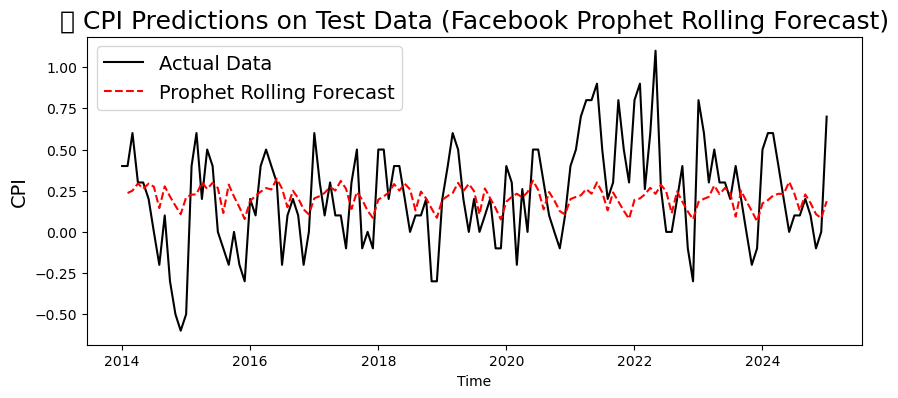

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Plot actual CPI values
plt.plot(df_prophet.loc[df_prophet['ds'] >= end_time, 'ds'], df_prophet.loc[df_prophet['ds'] >= end_time, 'y'], 
         label="Actual Data", color="black")

# Plot Prophet rolling forecast
plt.plot(prophet_rolling_results.index, prophet_rolling_results['yhat'], 
         label="Prophet Rolling Forecast", linestyle="--", color="red")

plt.legend(fontsize=14)
plt.title("📈 CPI Predictions on Test Data (Facebook Prophet Rolling Forecast)", fontsize=18)
plt.ylabel("CPI", fontsize=14)
plt.xlabel("Time")
plt.show()


01:49:21 - cmdstanpy - INFO - Chain [1] start processing
01:49:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mkahs\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
01:49:22 - cmdstanpy - INFO - Chain [1] start processing
01:49:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mkahs\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
01:49:22 - cmdstanpy - INFO - Chain [1] start processing
01:49:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mkahs\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
01:49:23 - cmdstanp

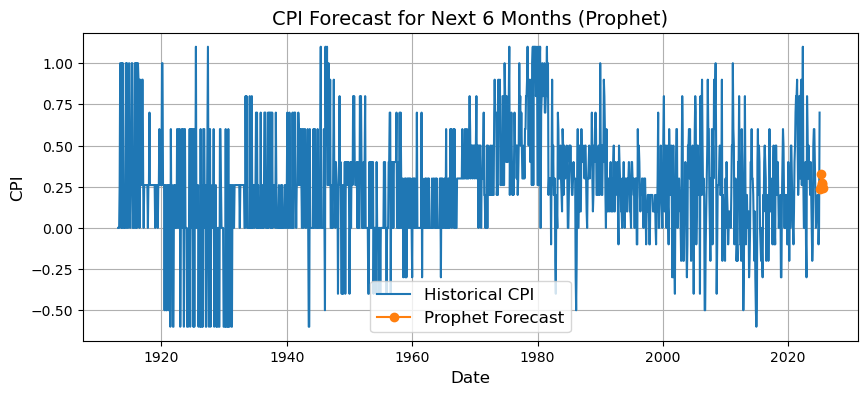

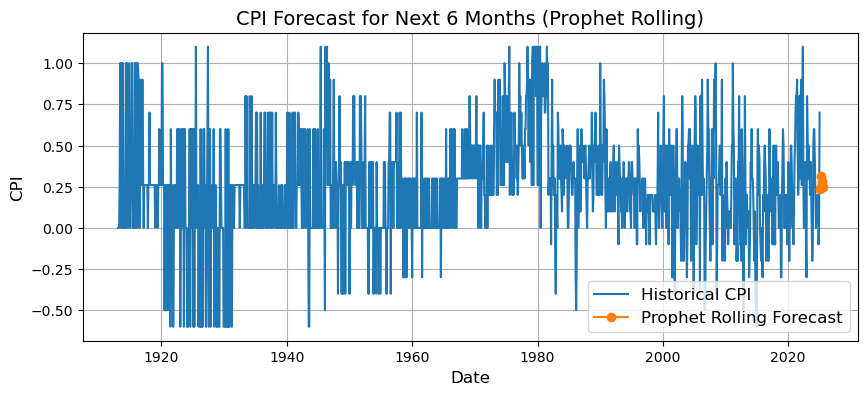

In [ ]:
from prophet import Prophet

# Ensure df is defined from the notebook extraction
if 'df' not in locals():
    raise ValueError("The dataset 'df' is not defined. Please provide a DataFrame with CPI time series data.")

# Convert dataset to Prophet format
df_prophet = df.reset_index()[['timestamp', 'CPI']]
df_prophet.columns = ['ds', 'y']

# --- 1. Standard Prophet Forecast --- #
prophet_model = Prophet(seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(df_prophet)

# Generate future dates for 6 months
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)

# Extract forecasted values for the next 6 months
prophet_forecast_df = forecast[['ds', 'yhat']].iloc[-6:]
prophet_forecast_df.columns = ['Date', 'CPI_Forecast']

# --- 2. Prophet Rolling Forecast --- #
roll_end_time = df_prophet['ds'].max()
prophet_roll_forecast_dates = []
prophet_roll_forecast_values = []
prophet_roll_train = df_prophet.copy()

for _ in range(6):
    prophet_roll_model = Prophet(seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    prophet_roll_model.fit(prophet_roll_train)

    future_roll = prophet_roll_model.make_future_dataframe(periods=1, freq='M')
    forecast_roll = prophet_roll_model.predict(future_roll)

    prediction = forecast_roll[['ds', 'yhat']].iloc[-1]

    prophet_roll_forecast_dates.append(prediction['ds'])
    prophet_roll_forecast_values.append(float(prediction['yhat']))

    # Append forecast to training data
    prophet_roll_train = prophet_roll_train._append({'ds': prediction['ds'], 'y': prediction['yhat']}, ignore_index=True)

# Create DataFrame for rolling forecast
prophet_roll_forecast_df = pd.DataFrame({'Date': prophet_roll_forecast_dates, 'CPI_Forecast': prophet_roll_forecast_values})

# Save forecasts to Excel files
prophet_output_file = "CPI_Forecast_Prophet_Next_6_Months.xlsx"
prophet_roll_output_file = "CPI_Forecast_Prophet_Rolling_Next_6_Months.xlsx"

prophet_forecast_df.to_excel(prophet_output_file, index=False)
prophet_roll_forecast_df.to_excel(prophet_roll_output_file, index=False)

# --- Plotting Results --- #
plt.figure(figsize=(10, 4))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Historical CPI", linestyle='-')
plt.plot(prophet_forecast_df['Date'], prophet_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Prophet Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 6 Months (Prophet)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Historical CPI", linestyle='-')
plt.plot(prophet_roll_forecast_df['Date'], prophet_roll_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Prophet Rolling Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 6 Months (Prophet Rolling)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()




In [21]:
prophet_roll_forecast_df.head(10)

,Date,CPI_Forecast
0,2025-01-31,0.235517
1,2025-02-28,0.251319
2,2025-03-31,0.315775
3,2025-04-30,0.278652
4,2025-05-31,0.284146
5,2025-06-30,0.246597


In [22]:
prophet_forecast_df.head(10)

,Date,CPI_Forecast
1344,2025-01-31,0.235517
1345,2025-02-28,0.251289
1346,2025-03-31,0.325207
1347,2025-04-30,0.273889
1348,2025-05-31,0.266414
1349,2025-06-30,0.244133


02:30:11 - cmdstanpy - INFO - Chain [1] start processing
02:30:11 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mkahs\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
02:30:11 - cmdstanpy - INFO - Chain [1] start processing
02:30:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mkahs\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
02:30:12 - cmdstanpy - INFO - Chain [1] start processing
02:30:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mkahs\AppData\Roaming\Python\Python310\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
02:30:12 - cmdstanp

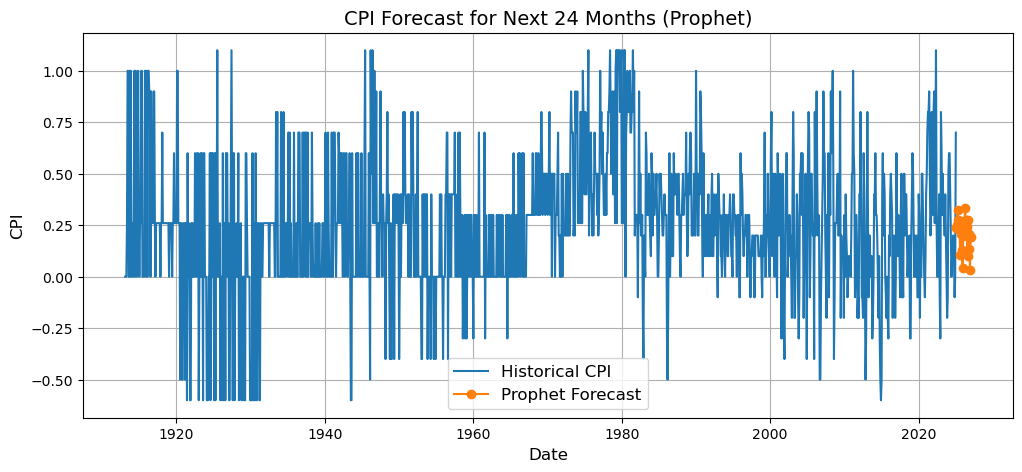

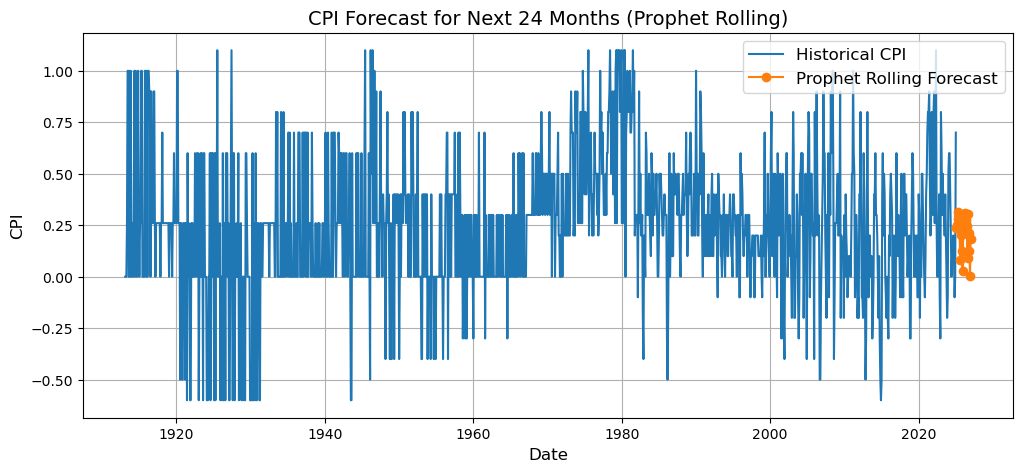

In [23]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Ensure df is defined from the notebook extraction
if 'df' not in locals():
    raise ValueError("The dataset 'df' is not defined. Please provide a DataFrame with CPI time series data.")

# Convert dataset to Prophet format
df_prophet = df.reset_index()[['timestamp', 'CPI']]
df_prophet.columns = ['ds', 'y']

# --- 1. Standard Prophet Forecast for 24 Months --- #
prophet_model = Prophet(seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(df_prophet)

# Generate future dates for 24 months
future = prophet_model.make_future_dataframe(periods=24, freq='M')
forecast = prophet_model.predict(future)

# Extract forecasted values for the next 24 months
prophet_forecast_df = forecast[['ds', 'yhat']].iloc[-24:]
prophet_forecast_df.columns = ['Date', 'CPI_Forecast']

# --- 2. Prophet Rolling Forecast for 24 Months --- #
roll_end_time = df_prophet['ds'].max()
prophet_roll_forecast_dates = []
prophet_roll_forecast_values = []
prophet_roll_train = df_prophet.copy()

for _ in range(24):
    prophet_roll_model = Prophet(seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    prophet_roll_model.fit(prophet_roll_train)

    future_roll = prophet_roll_model.make_future_dataframe(periods=1, freq='M')
    forecast_roll = prophet_roll_model.predict(future_roll)

    prediction = forecast_roll[['ds', 'yhat']].iloc[-1]

    prophet_roll_forecast_dates.append(prediction['ds'])
    prophet_roll_forecast_values.append(float(prediction['yhat']))

    # Append forecast to training data
    prophet_roll_train = prophet_roll_train._append({'ds': prediction['ds'], 'y': prediction['yhat']}, ignore_index=True)

# Create DataFrame for rolling forecast
prophet_roll_forecast_df = pd.DataFrame({'Date': prophet_roll_forecast_dates, 'CPI_Forecast': prophet_roll_forecast_values})

# Save forecasts to Excel files
prophet_output_file = "CPI_Forecast_Prophet_Next_24_Months.xlsx"
prophet_roll_output_file = "CPI_Forecast_Prophet_Rolling_Next_24_Months.xlsx"

prophet_forecast_df.to_excel(prophet_output_file, index=False)
prophet_roll_forecast_df.to_excel(prophet_roll_output_file, index=False)

# --- Plotting Results --- #
plt.figure(figsize=(12, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Historical CPI", linestyle='-')
plt.plot(prophet_forecast_df['Date'], prophet_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Prophet Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 24 Months (Prophet)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Historical CPI", linestyle='-')
plt.plot(prophet_roll_forecast_df['Date'], prophet_roll_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="Prophet Rolling Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 24 Months (Prophet Rolling)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()

# # Return saved file paths
# prophet_output_file, prophet_roll_output_file


In [24]:
prophet_roll_forecast_df.head(30)

,Date,CPI_Forecast
0,2025-01-31,0.235517
1,2025-02-28,0.251319
2,2025-03-31,0.315775
3,2025-04-30,0.278652
4,2025-05-31,0.284146
5,2025-06-30,0.246597
6,2025-07-31,0.081250
7,2025-08-31,0.282763
8,2025-09-30,0.201570
9,2025-10-31,0.123536


In [25]:
prophet_forecast_df.head(30)

,Date,CPI_Forecast
1344,2025-01-31,0.235517
1345,2025-02-28,0.251289
1346,2025-03-31,0.325207
1347,2025-04-30,0.273889
1348,2025-05-31,0.266414
1349,2025-06-30,0.244133
1350,2025-07-31,0.106760
1351,2025-08-31,0.268620
1352,2025-09-30,0.207048
1353,2025-10-31,0.131548
